<a href="https://colab.research.google.com/github/tarabelo/PIAC-2526/blob/main/06_B%C3%BAsqueda_adaptativa_de_Grover_(GAS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit[visualization]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 40.5 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=64ae1b9d1d6e45457d351bb99d55b3528fc37667caa5e1d731f89daf7030a656
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


# **Búsqueda adaptativa de Grover (GAS)**

Presentado en 1966 (https://arxiv.org/abs/quant-ph/9607014) busca encontrar el mínimo de una función $g(x)$ usando el algoritmo de búsqueda de Grover.

El proceso es como sigue:

1. Se elige un valor $x_0$ aleatorio y se computa $g(x_0)$
1. Se define un oráculo $f:\{0,1\}^n \rightarrow \{0,1\}$ de la forma:
$$
f(y) =
\begin{cases}
1, \text{si } g(y) < g(x_0)\\
0, \text{si } \text{ en otro caso}
\end{cases}
$$
1. Se usa el algoritmo de Grover para encontrar un $y$ ($\mathcal{O}\left(\sqrt{2^n}\right)$ evaluaciones).
1. Se hace $x_0=y$ y se vuelve al punto 2 hasta encontrar el mínimo.

# **Implementación del oráculo**

El oráculo GAS puede ser complejo de implementar.

Para una función QUBO es más simple.


### **Ejemplo**: Implementación de la función $g(x)=-2x_0x_2-x_1x_2-x_0+2x_1-3x_2$

Necesitamos 3 cúbits para representar las $x$.

Es fácil ver que $-7 \le g(x) \le 2$, por lo que necesitamos un mínimo de 4 bits para representar las $g(x).

Un ejemplo de circuito:

<br>
<center><img src="https://drive.google.com/uc?export=view&id=1IZPRKNSCJH4xcuNedx6iJMB8VU--OaOW" alt="Ejemplo oraculo GAS" width="700"  /></center>
<br>

Necesitamos implementar las puertas de suma.


# **Suma en el dominio de Fourier (_phase encoding_)**

Para hacer la suma, podemos codificar los coeficientes mediante codificación en la fase.

Así, un número entero $j$ de $n$-bits tiene la siguiente codificación:

$$
\text{QFT}(|j\rangle) = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} \exp\left(\frac{2\pi i}{2^n}jk\right)|k\rangle
$$

Por ejemplo, el 0 se representa como:

$$
\frac{1}{\sqrt{2^n}} \sum_{j=0}^{2^n-1} \exp\left(\frac{2\pi i}{2^n}0j\right)|j\rangle = \frac{1}{\sqrt{2^n}} \sum_{j=0}^{2^n-1} |j\rangle
$$

Ya que la QFT de $|0\rangle$ es $|+\rangle^{\otimes n}$


Sea un entero $j \ge 0$ codificado en la fase al que queremos sumarle otro entero no negativo $l$ para obtener:

$$
\frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} \exp\left(\frac{2\pi i}{2^n}(j+l)k\right)|k\rangle
$$

Esta suma se puede hacer con puertas fase como se muestra en el siguiente circuito:

<center><img src="https://drive.google.com/uc?export=view&id=1ZSkZZhdM9KLNMvITQbro4ic9yYxcPuPU" alt="Suma phase encoding" width="300"  /></center>

Es decir, al cúbit $k_h$ se le aplica la puerta

$$
P\!\left(\frac{\pi}{2^{n-1-h}}\,l\right)
$$



## Funcionamiento
Sea $|k\rangle = |k_{n-1}\ldots k_0\rangle$ un estado base. Sea $k_h\in\{0,1\}$ el bit $h$-ésimo:

- Si el qubit $k_h$ vale 0 → la puerta no introduce fase.  
- Si el qubit $k_h$ vale 1 → añade fase  $\exp\left(\frac{i\pi\,l}{2^{n-1-h}}\right)$.


El estado $|k\rangle$ recibe por tanto la fase total:

$$
\prod_{h=0}^{n-1}
\exp\left(\frac{i \pi l\, k_h}{2^{n-1-h}}\right)
=
\exp\left({i\pi l \sum_{h=0}^{n-1} \frac{k_h}{2^{n-1-h}}}\right).
$$

Usando la expansión binaria, el entero $k$ se puede escribir:

$$
k = \sum_{h=0}^{n-1} k_h 2^h \implies \frac{k}{2^{n-1}} = \sum_{h=0}^{n-1} \frac{k_h}{2^{n-1-h}}
$$


Por tanto, la fase total aplicada resulta:

$$
\exp\left(\frac{i \pi l k}{2^{n-1}}\right)
= \exp\left(\frac{2i \pi l k}{2^{n}}\right).
$$

## Resultado final
Aplicar este circuito a un entero $j$ codificado en la fase como

$$
\frac{1}{\sqrt{2^n}}
\sum_{k=0}^{2^{n-1}} \exp\left(\frac{2\pi i}{2^n}jk\right)|k\rangle
$$

produce:

$$
\boxed{
\frac{1}{\sqrt{2^n}}
\sum_{k=0}^{2^{n-1}} \exp\left(\frac{2\pi i}{2^n}(j+l)k\right)|k\rangle
}
$$

lo cual implementa la suma de enteros en codificación de fase.

Aplicando la QFT inversa:

$$
\text{QFT}^{-1}\left(\frac{1}{\sqrt{2^n}}
\sum_{k=0}^{2^{n-1}} \exp\left(\frac{2\pi i}{2^n}(j+l)k\right)|k\rangle\right) = j+l
$$

### Números negativos

Usando complemento a 2 para representar enteros negativos, la representación binaria de $l\lt 0$ es:

$$
l = 2^n-|l| = 2^n + l
$$

Por lo tanto, la fase aplicada por el circuito anterior al $h$-ésimo bit será:

$$
\exp\left(\frac{i\pi(2^n+l)}{2^{n-1-h}}\right) = \exp\left(\frac{i\pi\,2^n}{2^{n-1-h}}\right) \exp\left(\frac{i\pi\,l}{2^{n-1-h}}\right) = \exp\left(\frac{i\pi\,l}{2^{n-1-h}}\right).
$$

ya que:

$$
\exp\left(\frac{i\pi\,2^n}{2^{n-1-h}}\right) = \exp\left(i\pi\,2^{h+1}\right) = 1
$$

Es decir, el circuito nos sirve para números negativos y positivos.

**Ejemplo**: Función que devuelve una puerta que suma un entero $l$ en phase encoding

In [22]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit import Gate
import numpy as np

def pAddGate(l: int, n: int) -> Gate:
  """
  Devuelve un qiskit.circuit.Gate que ejecuta una suma +l en el dominio de Fourier
  de un valor entero de n cúbits.
  n debe ser sufucientemente grande para reprersentar el valor de la suma

  Argumentos:
    l: valor a sumar (int)
    n: numero de cúbits (int)
    controlled: Indica si la puerta está controlada
    num_ctrl_qubits: Numero de bits de control si controlled=True
  """
  qc = QuantumCircuit(n)

  for h in range(n):
    qc.p((np.pi*l)/2**(n-1-h),h)

  gate = qc.to_gate(label="Suma "+str(l))

  return(gate)

Sumamos dos enteros a+b de 4 bits en complemento a 2 $\implies$ $-8 \le a,b \le 7$ y $-8 \le a+b \le 7$



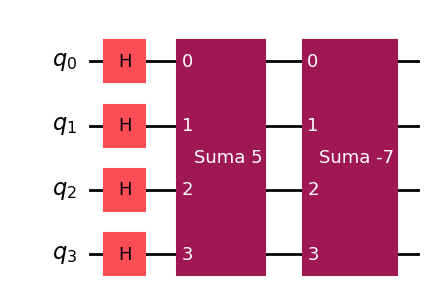

In [23]:
n = 4

a = 5
b = -7

qc = QuantumCircuit(n)

s1 = pAddGate(a,n)
s2 = pAddGate(-7,n)

# 0 en el espacio de fases
qc.h(range(n))

qc.append(s1, list(range(n)))
qc.append(s2, list(range(n)))

qc.draw('mpl')

In [24]:
# Vemos el vector de estado
e = Statevector.from_instruction(qc)
e.draw('latex')

<IPython.core.display.Latex object>

In [25]:
# Aplicamos la QFT inversa
from qiskit.circuit.library import QFTGate

qc_inverso = qc.compose(QFTGate(n).inverse())

e = Statevector.from_instruction(qc_inverso)
e.draw('latex')

<IPython.core.display.Latex object>

### **Ejemplo**: Implementación de la función $g(x)=-2x_0x_2-x_1x_2-x_0+2x_1-3x_2$ (continuación)

Tenemos que convertir la puerta de suma en una puerta controlada.

In [52]:
def CpAddGate(l: int, n: int, num_ctrl_qubits=1):
  """
  Devuelve un qiskit.circuit.Gate que ejecuta una suma +l en el dominio de Fourier
  de un valor entero de n cúbits.
  n debe ser sufucientemente grande para reprersentar el valor de la suma

  Argumentos:
    l: valor a sumar (int)
    n: numero de cúbits (int)
    num_ctrl_qubits: Numero de bits de control si controlled=True
  """
  qc = QuantumCircuit(n)

  s1 = pAddGate(n, l)
  qc.append(s1, list(range(n)))
  #qc = qc.append(pAddGate(l,n),list(range(n)))

  #gate = qc.to_gate()
  #gate = gate.control(num_ctrl_qubits)
  display(qc.draw('mpl'))

  return(qc)

In [53]:
qbits = [0,1,2]
ancillas = [3,4,5,6]
qc = QuantumCircuit(len(qbits)+len(ancillas))
resta2 = CpAddGate(-2, len(ancillas), 2)

CircuitError: 'Register size must be non-negative.'

In [27]:
n = 3
nancillas = 4
x = QuantumRegister(n, name='x')
ancillas = QuantumRegister(nancillas, name='ancillas')
qc = QuantumCircuit(x, ancillas)

# Probamos con puertas controladas
qc = QuantumCircuit(x,ancillas)
resta2 = CpAddGate(-2, nancillas, 2)
resta1a = CpAddGate(-1, nancillas, 2)
resta1b = CpAddGate(-1, nancillas, 1)
suma2 = CpAddGate(2, nancillas,  1)
resta3 = CpAddGate(-2, nancillas, 1)

qc.append(resta2, [x[0], x[2]] + list(ancillas))  # primero los qubits de control, luego los target
qc.append(resta1a, [x[1], x[2]] + list(ancillas))  # primero los qubits de control, luego los target
qc.append(resta1b, [x[0]] + list(ancillas))  # primero los qubits de control, luego los target
qc.append(suma2, [x[1]] + list(ancillas))  # primero los qubits de control, luego los target
qc.append(resta3, [x[2]] + list(ancillas))  # primero los qubits de control, luego los target
qc.draw("mpl")


CircuitError: 'The amount of qubit(0)/clbit(0) arguments does not match the gate expectation (4).'

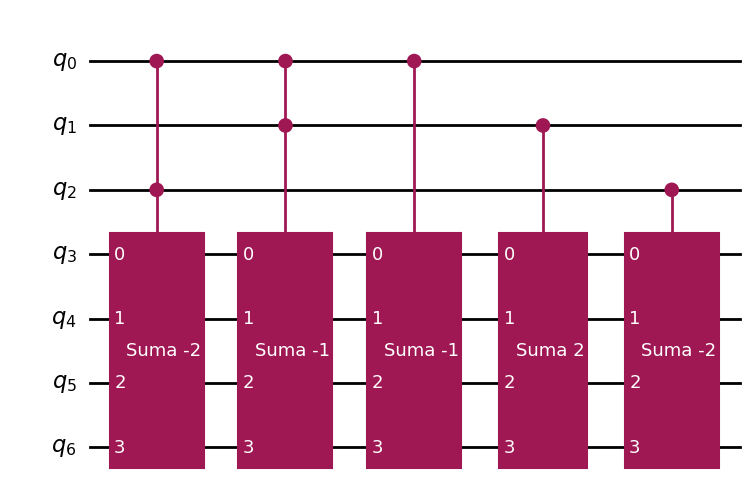

In [8]:
# Probamos con puertas controladas
qbits = [0,1,2]
ancillas = [3,4,5,6]
qc = QuantumCircuit(len(qbits)+len(ancillas))
resta2 = pAddGate(-2, len(ancillas), True, 2)
resta1a = pAddGate(-1, len(ancillas), True, 2)
resta1b = pAddGate(-1, len(ancillas), True, 1)
suma2 = pAddGate(2, len(ancillas), True, 1)
resta3 = pAddGate(-2, len(ancillas), True, 1)

qc.append(resta2, [0,2]+ancillas)  # primero los qubits de control, luego los target
qc.append(resta1a, [0,1]+ancillas)  # primero los qubits de control, luego los target
qc.append(resta1b, [0]+ancillas)  # primero los qubits de control, luego los target
qc.append(suma2, [1]+ancillas)  # primero los qubits de control, luego los target
qc.append(resta3, [2]+ancillas)  # primero los qubits de control, luego los target
qc.draw("mpl")

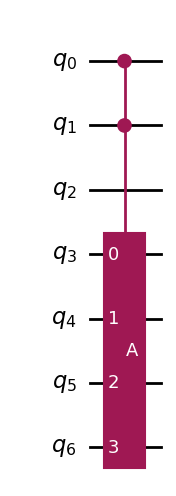

In [ ]:
from qiskit import QuantumCircuit



def my_subcircuit(n):
    qc = QuantumCircuit(n)
    qc.rx(0.5, 0)
    qc.ry(2, 1)
    return qc.to_gate(label="A")

qbits = [0,1,2]
ancillas = [3,4,5,6]

gate = my_subcircuit(len(ancillas))


controlled_gate = gate.control(num_ctrl_qubits=2)

qc = QuantumCircuit(len(qbits)+len(ancillas))
qc.append(controlled_gate, [0, 1]+ancillas)  # primero los qubits de control, luego los target
qc.draw("mpl")

In [ ]:
# Función para obtener y mostrar el vector de estado
def obten_estado(qcirc, etiqueta="|psi> = ", bloch=False):
  estado = Statevector.from_instruction(qcirc)
  display(estado.draw('latex', prefix=etiqueta, max_size=2**qc.num_qubits))
  if bloch:
    display(estado.draw('bloch'))

/tmp/ipython-input-1038078757.py:12: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_qiskit.compose(QFT(n),inplace=True)


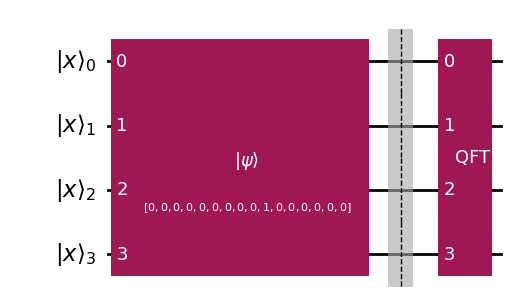

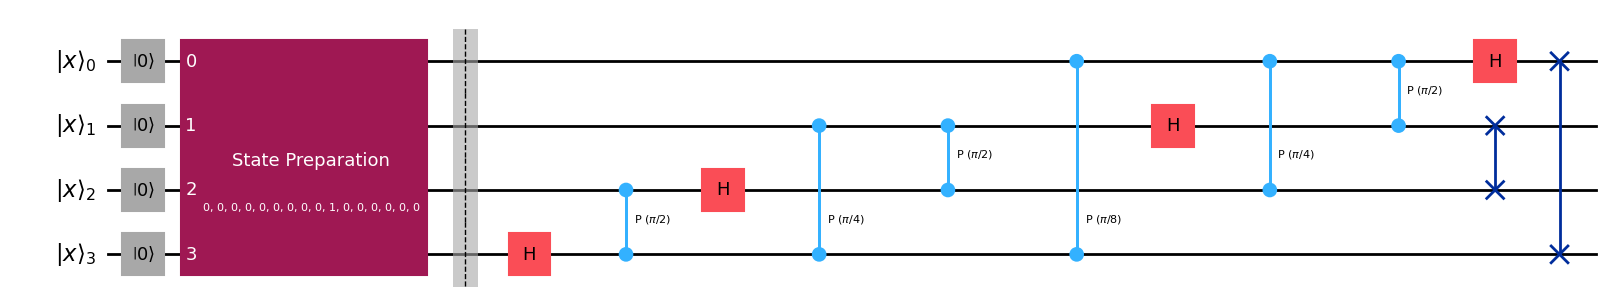

<IPython.core.display.Latex object>

In [ ]:
from qiskit.circuit.library import QFT
from qiskit import QuantumRegister
#n = 4 # Tres cúbits
v = l # valor a calcular

x = QuantumRegister(n, name='|x\\rangle')
qft_qiskit = QuantumCircuit(x)
qft_qiskit.initialize(Statevector.from_int(v, dims=2**n))

qft_qiskit.barrier()

qft_qiskit.compose(QFT(n),inplace=True)

# Muesta el circuito
display(qft_qiskit.draw('mpl'))
display(qft_qiskit.decompose().draw('mpl'))

obten_estado(qft_qiskit, 'QFT|101\\rangle =')